# Data Preparation

## Import Libraries

In [26]:
import pandas as pd 
import numpy as np 
import scipy as sp 

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

# Importar funciones necesarias
from pyspark.sql.functions import col, to_date, weekofyear,year, month, dayofmonth, sum
from pyspark.sql.functions import col, sum as spark_sum
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.types import IntegerType
# Puedes obtener estadísticas específicas para una columna
from pyspark.sql.functions import mean, min, max
from pyspark.sql.functions import approx_count_distinct
from pyspark.sql.window import Window
from pyspark.sql import functions as F


## Import Data

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers (https://archive.ics.uci.edu/dataset/502/online+retail+ii).

In [2]:
spark = SparkSession.builder.appName("Appmain").getOrCreate()
# Ruta del archivo Excel
ruta_archivo_excel = 'datasets/online_retail_II.xlsx'

# Leer el archivo Excel usando pandas
df_pandas_1 = pd.read_excel(ruta_archivo_excel, sheet_name='Year 2009-2010')
df_pandas_2 = pd.read_excel(ruta_archivo_excel, sheet_name='Year 2010-2011')
# Comprobar que ambos DataFrames tienen las mismas columnas
if list(df_pandas_1.columns) == list(df_pandas_2.columns):
    # Unir los DataFrames usando concat
    # axis=0 para concatenar por filas (verticalmente)
    dataframe_u = pd.concat([df_pandas_1, df_pandas_2], ignore_index=True)

    print("DataFrames unidos exitosamente:")
    print(dataframe_u)

else:
    print("Los DataFrames no tienen las mismas columnas, no se pueden unir.")
# Convertir el DataFrame de pandas a un DataFrame de PySpark
df_spark = spark.createDataFrame(dataframe_u)

# Ruta de destino para el archivo Parquet
ruta_destino_parquet = 'datasets/online_retail.parquet'

# Suponiendo que tienes un DataFrame llamado df que deseas convertir a Parquet
# Guardar el DataFrame como archivo Parquet
df_spark.write.mode("overwrite").parquet(ruta_destino_parquet)


DataFrames unidos exitosamente:
        Invoice StockCode                          Description  Quantity  \
0        489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1        489434    79323P                   PINK CHERRY LIGHTS        12   
2        489434    79323W                  WHITE CHERRY LIGHTS        12   
3        489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4        489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...         ...       ...                                  ...       ...   
1067366  581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
1067367  581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
1067368  581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
1067369  581587     22138        BAKING SET 9 PIECE RETROSPOT          3   
1067370  581587      POST                              POSTAGE         1   

                InvoiceDate  Price  Customer ID        

## Exploratory data analysis (EDA)

In [36]:

# Crear una nueva sesión de Spark
spark = SparkSession.builder\
        .master("local")\
        .appName("Appretail")\
        .config('spark.ui.port', '4051')\
        .getOrCreate()

# Leer el archivo Parquet
df_parquet = spark.read.parquet("datasets/online_retail.parquet")

# Mostrar el contenido del archivo Parquet
df_parquet.show()

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|    22041|RECORD FRAME 7" S...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|    13085.0|United Kingdom|
| 489434|    22064|PINK DOUGHNUT TRI...|      24|2009-12-01 07:45:00| 1.65|    13085.0|United Kingdom|
| 489434|    21871| SAVE THE PLANET MUG|      24|2009-12-01 07:45:00| 1.2

In [37]:
# Mostrar el esquema del DataFrame de PySpark
df_parquet.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)



In [38]:
print((df_parquet.count(), len(df_parquet.columns)))

(1067371, 8)


In [39]:
# Verificar valores nulos por columna y contarlos
null_counts = df_parquet.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df_parquet.columns])
null_counts.show()

+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|      0|        0|          0|       0|          0|    0|          0|      0|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+



In [40]:
# Para obtener claves únicas de múltiples columnas
multiple_unique_keys = df_parquet.select("Quantity").distinct()
multiple_unique_keys.show()

+--------+
|Quantity|
+--------+
|      26|
|      29|
|     -91|
|    2040|
|    -250|
|    -251|
|    -635|
|    -380|
|    -725|
|      65|
|    1010|
|    -670|
|    1224|
|     222|
|     270|
|     -58|
|    -109|
|     730|
|     293|
|    -723|
+--------+
only showing top 20 rows



In [41]:
# Aplicar regex para eliminar caracteres no numéricos y convertir a tipo Integer
df_parquet = df_parquet.withColumn("Invoice", regexp_replace(col("Invoice"), "[^0-9]", "").cast("string"))
# Sobrescribir la columna 'Quantity' con su versión convertida a tipo 'integer'
df_parquet = df_parquet.withColumn("Quantity", df_parquet["Quantity"].cast(IntegerType()))
# Sobrescribir la columna 'Customer ID' con su versión convertida a tipo 'integer'
df_parquet = df_parquet.withColumn("Customer ID", df_parquet["Customer ID"].cast("string"))
# Analizar la Venta creacion de la columna Price por Quantity
df_parquet = df_parquet.withColumn("Sales", col("Price") * col("Quantity"))

# Mostrar el DataFrame después de la transformación
df_parquet.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Sales: double (nullable = true)



In [42]:
# Obtener solo las columnas numéricas
numeric_columns = [col_name for col_name, col_type in df_parquet.dtypes if col_type in ['int', 'bigint', 'double', 'float']]
# Estadísticas descriptivas de las columnas numéricas

# Calcular estadísticas descriptivas solo para las columnas numéricas
df_parquet.select(numeric_columns).describe().show()

+-------+------------------+------------------+------------------+
|summary|          Quantity|             Price|             Sales|
+-------+------------------+------------------+------------------+
|  count|           1067371|           1067371|           1067371|
|   mean|   9.9388984711033| 4.649387727431153|18.069865649320274|
| stddev|172.70579407675189|123.55305872146322| 292.4202232785709|
|    min|            -80995|         -53594.36|         -168469.6|
|    max|             80995|           38970.0|          168469.6|
+-------+------------------+------------------+------------------+



In [43]:

categorical_columns = [col_name for col_name, col_type in df_parquet.dtypes if col_type not in ['int', 'bigint', 'double', 'float']]
df_parquet.select([approx_count_distinct(col).alias(col) for col in categorical_columns]).show()

+-------+---------+-----------+-----------+-----------+-------+
|Invoice|StockCode|Description|InvoiceDate|Customer ID|Country|
+-------+---------+-----------+-----------+-----------+-------+
|  57752|     4811|       6157|      50247|       6124|     43|
+-------+---------+-----------+-----------+-----------+-------+



In [44]:
# Crear nuevas columnas para día, semana y mes
df_parquet = df_parquet.withColumn('Day', dayofmonth(col('InvoiceDate')))
df_parquet = df_parquet.withColumn('Week', weekofyear(col('InvoiceDate')))
df_parquet = df_parquet.withColumn('Month', month(col('InvoiceDate')))

# Obtener la cantidad de ventas o movimientos por día, semana y mes
sales_by_day = df_parquet.groupBy('Day').count().orderBy('Day')
sales_by_week = df_parquet.groupBy('Week').count().orderBy('Week')
sales_by_month = df_parquet.groupBy('Month').count().orderBy('Month')

In [45]:
df_parquet.show()

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+------------------+---+----+-----+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|             Sales|Day|Week|Month|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+------------------+---+----+-----+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|              83.4|  1|  49|   12|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|              81.0|  1|  49|   12|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|              81.0|  1|  49|   12|
| 489434|    22041|RECORD FRAME 7" S...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom|100.80000000000001|  1|  49|   12|
| 489434|    21232|STRAWBERRY CERAMI...| 

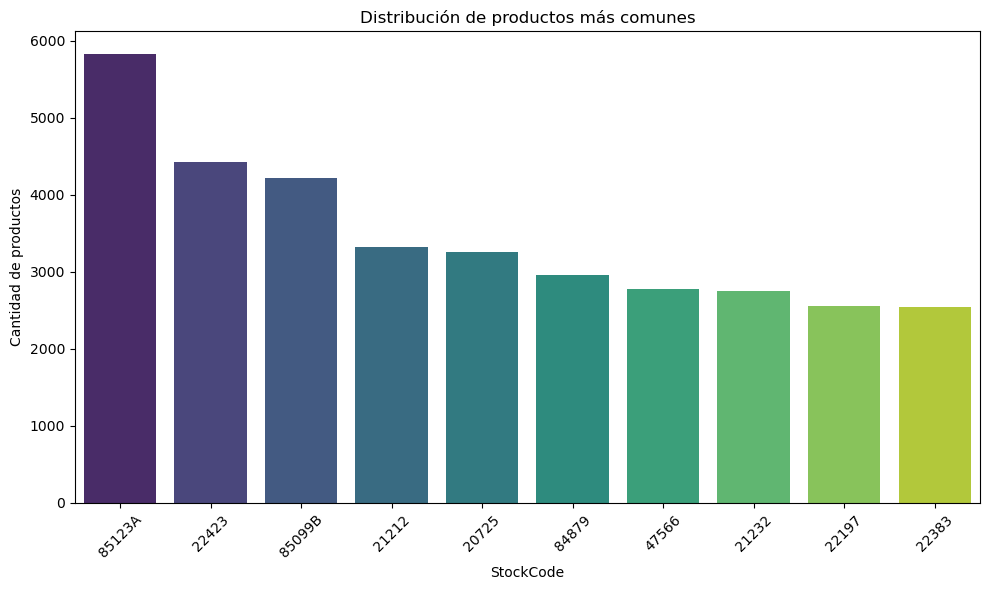

In [46]:
%matplotlib inline
# Obtener la cantidad de productos por 'StockCode' y convertir a Pandas DataFrame
products_count = df_parquet.groupBy('StockCode').count().orderBy('count', ascending=False).limit(10).toPandas()

# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='StockCode', y='count', data=products_count, hue='StockCode', palette='viridis', dodge=False, legend=False)
plt.xlabel('StockCode')
plt.ylabel('Cantidad de productos')
plt.title('Distribución de productos más comunes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

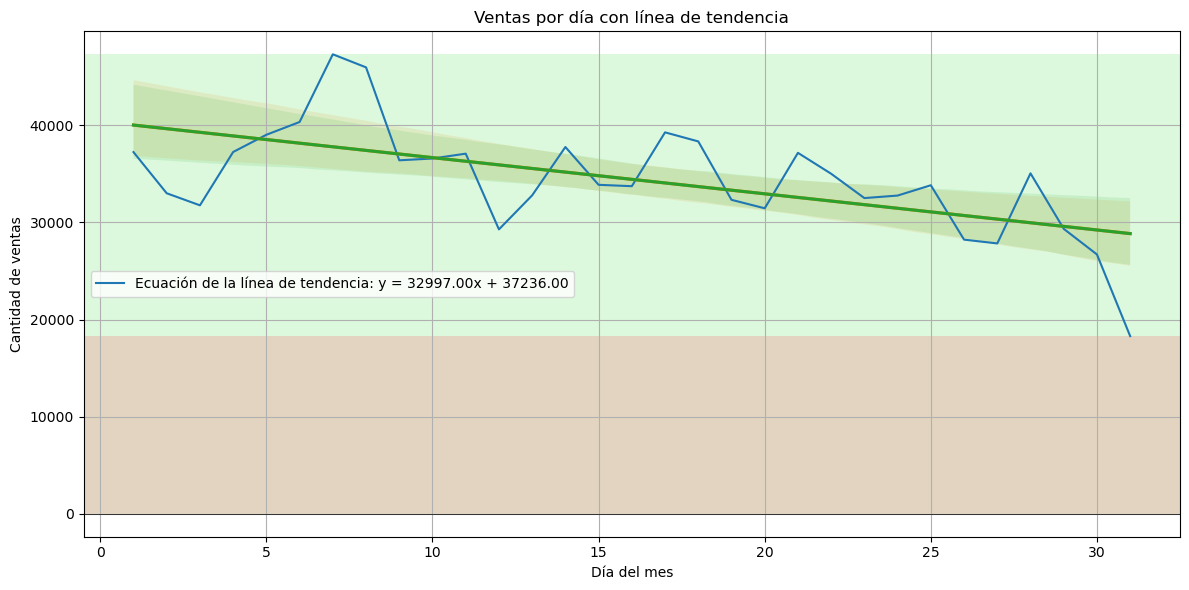

In [47]:
%matplotlib inline
# Ahora, puedes trazar las tendencias temporales utilizando estos datos agrupados
# Puedes utilizar herramientas de visualización como Matplotlib o Seaborn para graficar las tendencias temporales
# Dependiendo de tu preferencia y el nivel de detalle que desees en las tendencias.

# Convertir los resultados a un DataFrame de Pandas para trabajar con Seaborn
sales_by_day_pandas = sales_by_day.toPandas()
# Usar Seaborn para graficar las ventas por día con una línea de tendencia
plt.figure(figsize=(12, 6))
# Gráfico de líneas de las ventas por día
sns.lineplot(data=sales_by_day_pandas, x='Day', y='count', label='Ventas por día')
# Ajustar una línea de tendencia (regresión lineal)
sns.regplot(data=sales_by_day_pandas, x='Day', y='count', scatter=False, label='Línea de tendencia')


# Obtener los coeficientes de la regresión lineal
coefficients = sns.regplot(data=sales_by_day_pandas, x='Day', y='count', scatter=False).get_lines()[0].get_ydata()
slope, intercept = coefficients[1], coefficients[0]

# Mostrar la ecuación de la línea de tendencia en la leyenda del gráfico
equation = f'Ecuación de la línea de tendencia: y = {slope:.2f}x + {intercept:.2f}'


# Estilo del fondo del gráfico para presentación financiera
plt.axhline(0, color='black', linewidth=0.5)  # Línea base en 0
plt.axhspan(0, sales_by_day_pandas['count'].max(), facecolor='lightgreen', alpha=0.3)  # Fondo de color positivo
plt.axhspan(sales_by_day_pandas['count'].min(), 0, facecolor='lightcoral', alpha=0.3)  # Fondo de color negativo

plt.title('Ventas por día con línea de tendencia')
plt.xlabel('Día del mes')
plt.ylabel('Cantidad de ventas')
plt.legend([equation])
plt.grid(True)
plt.tight_layout()
plt.show()

# Puedes repetir este proceso para trazar las tendencias por semana y mes si lo deseas.

#### La ecuación y = 32997x + 37236 toma una forma específica.
- 32997*X es la pendiente de la línea de tendencia. Esto indica que, en promedio, se espera un aumento de aproximadamente 32,997 unidades en la cantidad de ventas cada vez que se incrementa el día (x) en una unidad. Entonces, si x aumenta en uno, las ventas (y) se esperan que aumenten en alrededor de 32,997 unidades, manteniendo todos los demás factores constantes
- La pendiente (32997) indica el cambio esperado en la cantidad de ventas por cada unidad adicional en el día del mes.
- El término constante (37236) puede interpretarse como la cantidad de ventas estimada al comienzo del mes (x = 0).
- Es decir, al principio del mes (día 1), se espera que las ventas comiencen alrededor de 37,236 unidades (y) y aumenten aproximadamente en 32,997 unidades por cada día adicional que avance el mes.

In [48]:
# Calcular la cantidad total vendida o movida para cada producto
products_sold = df_parquet.groupBy('StockCode', 'Description').agg(sum('Quantity').alias('TotalQuantitySold')).orderBy('TotalQuantitySold', ascending=False)

# Mostrar los productos más vendidos o movidos
products_sold.show()

+---------+--------------------+-----------------+
|StockCode|         Description|TotalQuantitySold|
+---------+--------------------+-----------------+
|    84077|WORLD WAR 2 GLIDE...|           108545|
|   85123A|WHITE HANGING HEA...|            92453|
|    84879|ASSORTED COLOUR B...|            81306|
|   85099B|JUMBO BAG RED RET...|            77671|
|    17003| BROCADE RING PURSE |            70700|
|    21977|PACK OF 60 PINK P...|            56575|
|    84991|60 TEATIME FAIRY ...|            54366|
|    22197|SMALL POPCORN HOLDER|            49616|
|    21212|PACK OF 72 RETROS...|            49344|
|    21212|PACK OF 72 RETRO ...|            46106|
|    22492|MINI PAINT SET VI...|            44124|
|    15036|ASSORTED COLOURS ...|            43556|
|    21213|PACK OF 72 SKULL ...|            40644|
|    22616|PACK OF 12 LONDON...|            40295|
|    84755|COLOUR GLASS T-LI...|            40110|
|    22178|VICTORIAN GLASS H...|            39738|
|    84568|GIRLS ALPHABET IR...

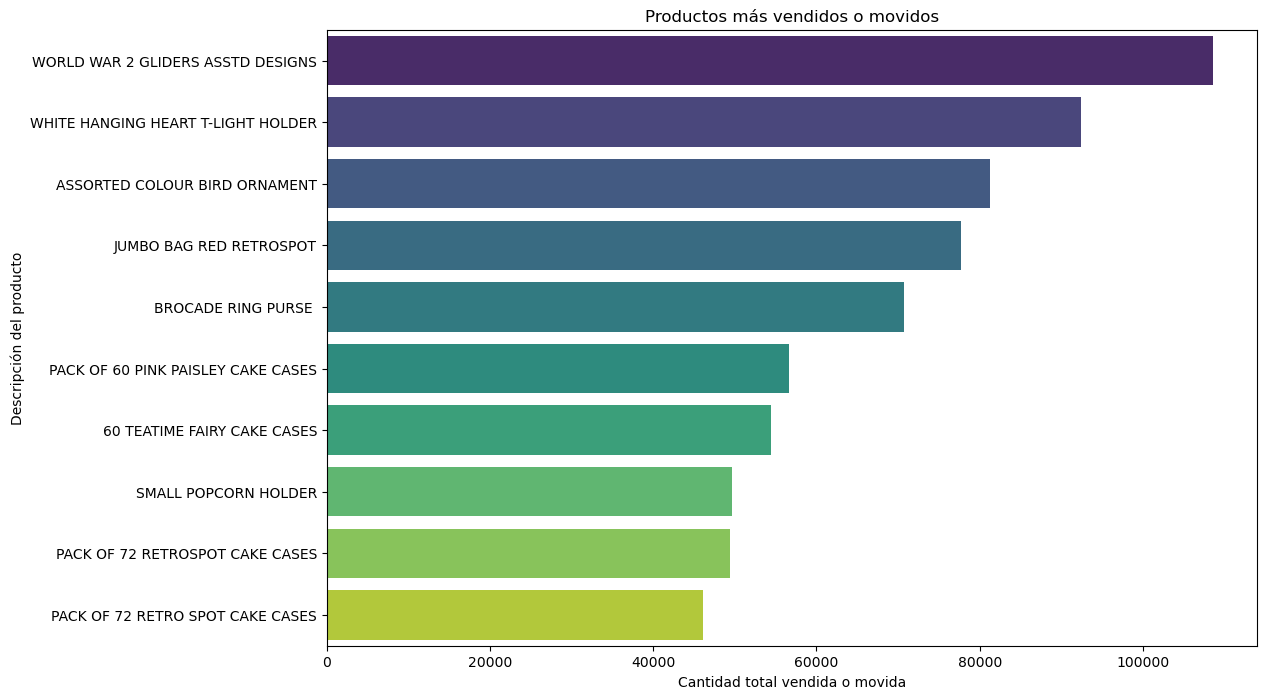

In [49]:
%matplotlib inline
# Convertir los resultados a un DataFrame de Pandas
products_sold_df = products_sold.toPandas()

# Graficar los productos más vendidos o movidos
plt.figure(figsize=(12, 8))
top_products = products_sold_df.head(10)  # Tomar los 10 productos principales
sns.barplot(x='TotalQuantitySold', y='Description', data=top_products, hue='Description', palette='viridis' , dodge=False)
plt.xlabel('Cantidad total vendida o movida')
plt.ylabel('Descripción del producto')
plt.title('Productos más vendidos o movidos')
plt.legend([], frameon=False)  # Deshabilitar la leyenda
plt.show()

In [50]:
# Suponiendo que tienes un DataFrame llamado 'df' con los datos
devoluciones_cancelaciones = df_parquet.filter(col('Quantity') < 0)
devoluciones_cancelaciones.show()

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+-------------------+---+----+-----+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|              Sales|Day|Week|Month|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+-------------------+---+----+-----+
| 489449|    22087|PAPER BUNTING WHI...|     -12|2009-12-01 10:33:00| 2.95|    16321.0|     Australia|-35.400000000000006|  1|  49|   12|
| 489449|   85206A|CREAM FELT EASTER...|      -6|2009-12-01 10:33:00| 1.65|    16321.0|     Australia| -9.899999999999999|  1|  49|   12|
| 489449|    21895|POTTING SHED SOW ...|      -4|2009-12-01 10:33:00| 4.25|    16321.0|     Australia|              -17.0|  1|  49|   12|
| 489449|    21896|  POTTING SHED TWINE|      -6|2009-12-01 10:33:00|  2.1|    16321.0|     Australia|-12.600000000000001|  1|  49|   12|
| 489449|    22083|PAPER CHAIN KIT

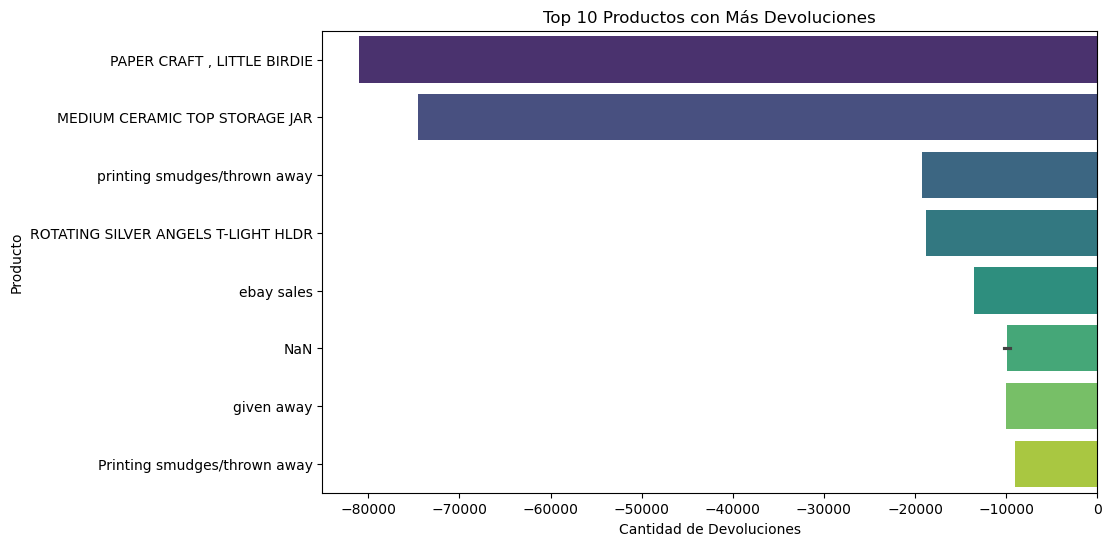

In [51]:
%matplotlib inline
# Obtener la suma de devoluciones por producto (agrupar por StockCode)
devoluciones_por_producto = devoluciones_cancelaciones.groupBy('StockCode', 'Description').sum('Quantity')
devoluciones_por_producto = devoluciones_por_producto.withColumnRenamed("sum(Quantity)", "TotalDevoluciones")

# Mostrar los resultados
#devoluciones_por_producto.show()
# Ordenar los datos para tomar los primeros 10 en términos de devoluciones
# Ordenar el DataFrame por la columna 'TotalDevoluciones' en orden ascendente
devoluciones_ordenadas = devoluciones_por_producto.orderBy('TotalDevoluciones')

# Seleccionar los 10 primeros registros después de ordenar
top_10_devoluciones = devoluciones_ordenadas.limit(10)

# Mostrar el contenido de top_10_devoluciones (si lo deseas)
#top_10_devoluciones.show()
# Convertir a Pandas para visualización
top_10_devoluciones_pd = top_10_devoluciones.toPandas()
# Crear el gráfico de barras con Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='TotalDevoluciones', y='Description', data=top_10_devoluciones_pd , hue='Description', palette='viridis')
plt.title('Top 10 Productos con Más Devoluciones')
plt.xlabel('Cantidad de Devoluciones')
plt.ylabel('Producto')
plt.show()

In [52]:
df_parquet.show()

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+------------------+---+----+-----+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|             Sales|Day|Week|Month|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+------------------+---+----+-----+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|              83.4|  1|  49|   12|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|              81.0|  1|  49|   12|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|              81.0|  1|  49|   12|
| 489434|    22041|RECORD FRAME 7" S...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom|100.80000000000001|  1|  49|   12|
| 489434|    21232|STRAWBERRY CERAMI...| 

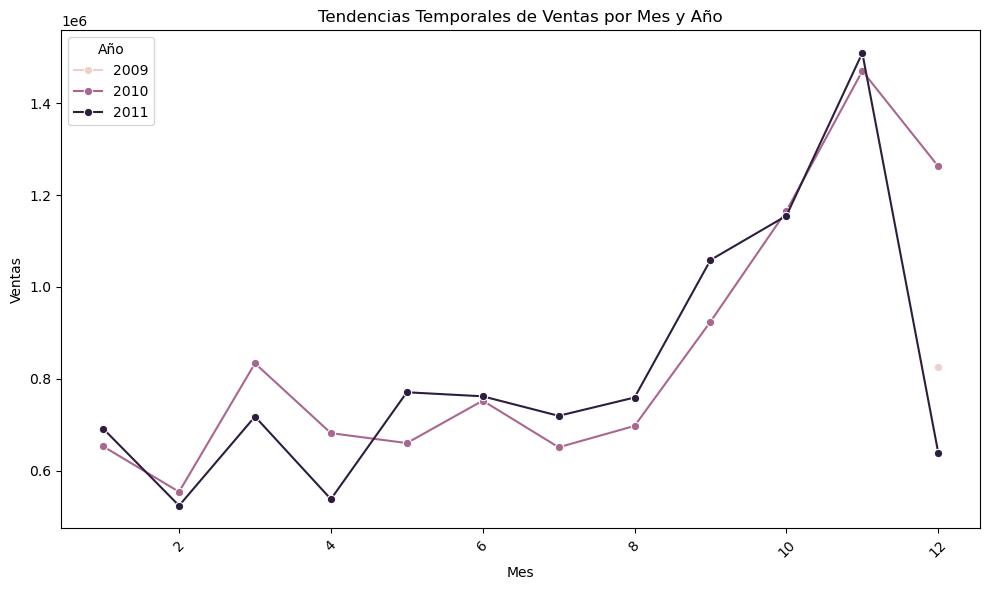

In [53]:
%matplotlib inline
# Suponiendo que tienes un DataFrame llamado 'df' con los datos
df_parquet_sales = df_parquet.filter(col('Sales') > 0)
#df_parquet_sales.show()

# Extraer el mes y el año de la columna InvoiceDate
df_monthly_sales = df_parquet_sales.withColumn("Year", year("InvoiceDate")).withColumn("Month", month("InvoiceDate"))
#df_monthly_sales.show()
# Agrupar por año y mes y sumar las ventas
monthly_sales = df_monthly_sales.groupBy("Year", "Month").sum("Sales").orderBy("Year", "Month")
#monthly_sales.show()
# Obtener los datos de PySpark DataFrame a Pandas DataFrame
monthly_sales_pandas = monthly_sales.toPandas()
#monthly_sales.show()
# Convertir el DataFrame de PySpark a un Pandas DataFrame
monthly_sales_pandas = monthly_sales.toPandas()

# Graficar la tendencia de ventas utilizando Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales_pandas, x='Month', y='sum(Sales)', hue='Year', marker='o')
plt.title('Tendencias Temporales de Ventas por Mes y Año')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.legend(title='Año')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [54]:
# Crear una copia del DataFrame
df_parquet_copia = df_parquet

# Crear columnas de entrada y salida en la copia
df_parquet_copia = df_parquet_copia.withColumn("Entrada", F.when(df_parquet_copia["Quantity"] > 0, df_parquet_copia["Quantity"]).otherwise(0))
df_parquet_copia = df_parquet_copia.withColumn("Salida", F.when(df_parquet_copia["Quantity"] < 0, -df_parquet_copia["Quantity"]).otherwise(0))

# Crear una ventana ordenada por fecha para calcular el inventario acumulado
window_spec = Window().partitionBy("StockCode").orderBy("InvoiceDate")

# Calcular el inventario acumulado en la copia
df_parquet_copia = df_parquet_copia.withColumn("InventarioAcumulado", F.sum("Entrada").over(window_spec) - F.sum("Salida").over(window_spec))

# Mostrar el DataFrame resultante
df_parquet_copia.show()

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+------------------+---+----+-----+-------+------+-------------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|             Sales|Day|Week|Month|Entrada|Salida|InventarioAcumulado|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+------------------+---+----+-----+-------+------+-------------------+
| 489437|    10002|INFLATABLE POLITI...|      12|2009-12-01 09:08:00| 0.85|    15362.0|United Kingdom|              10.2|  1|  49|   12|     12|     0|                 12|
| 490063|    10002|INFLATABLE POLITI...|       1|2009-12-03 13:49:00| 0.85|    17271.0|United Kingdom|              0.85|  3|  49|   12|      1|     0|                 14|
| 490063|    10002|INFLATABLE POLITI...|       1|2009-12-03 13:49:00| 0.85|    17271.0|United Kingdom|              0.85|  3|  49|   12|    

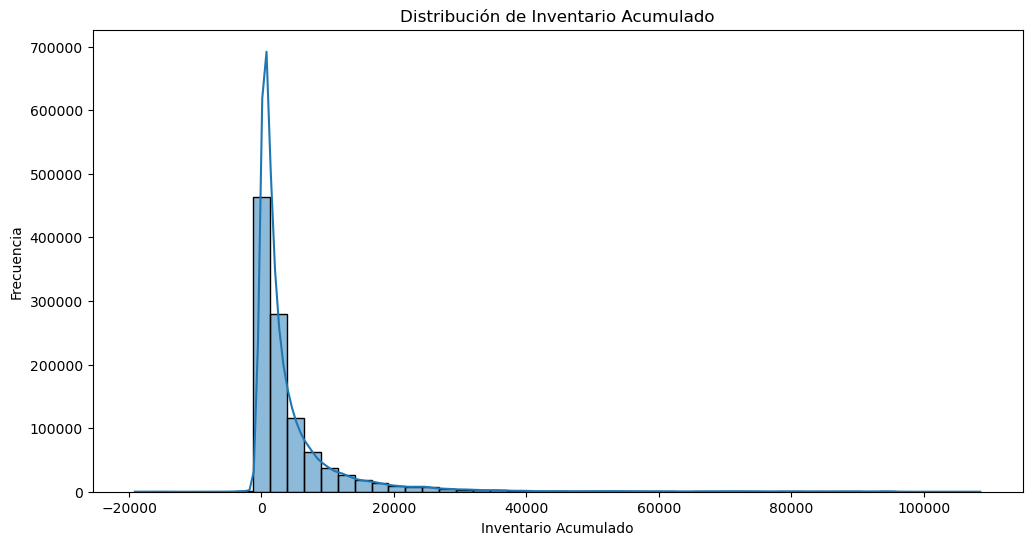

In [55]:
%matplotlib inline
# Supongamos que df_parquet es tu DataFrame original con las columnas relevantes
df = df_parquet_copia.select("InvoiceDate", "StockCode", "InventarioAcumulado").toPandas()

# Asegúrate de que la columna InvoiceDate sea de tipo datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Ordena los datos por fecha y StockCode
df.sort_values(['StockCode', 'InvoiceDate'], inplace=True)

# Graficar histograma para la distribución de InventarioAcumulado
plt.figure(figsize=(12, 6))
sns.histplot(df['InventarioAcumulado'], bins=50, kde=True)
plt.title('Distribución de Inventario Acumulado')
plt.xlabel('Inventario Acumulado')
plt.ylabel('Frecuencia')
plt.show()

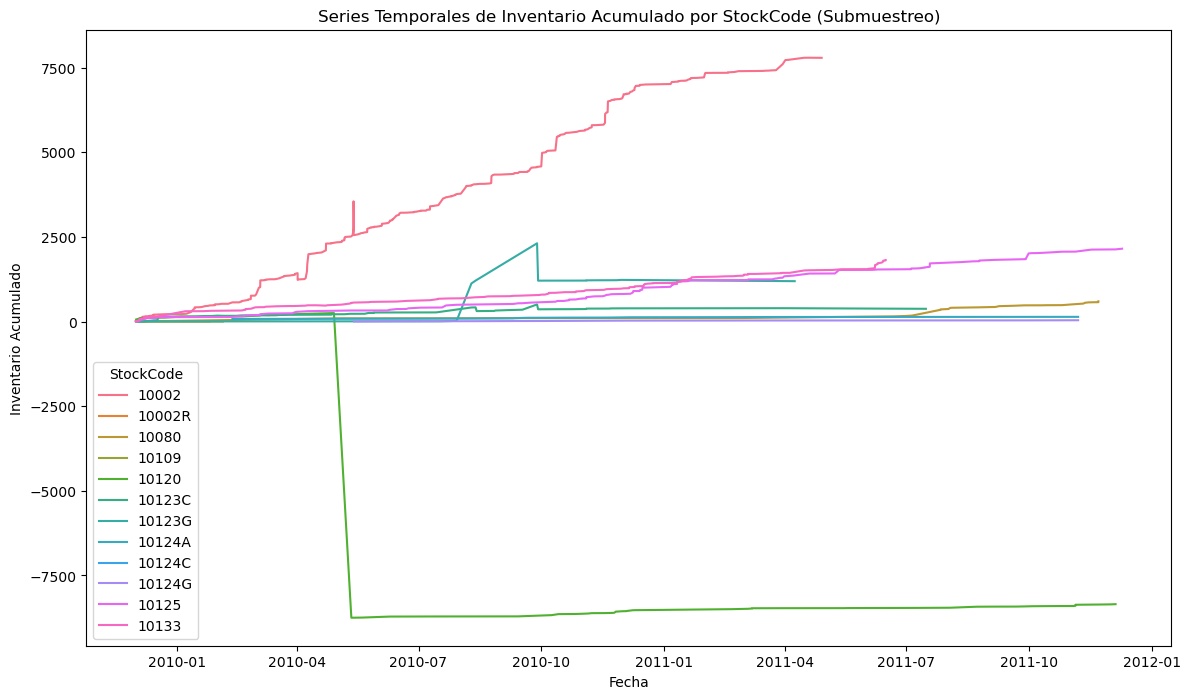

In [56]:
%matplotlib inline
# Tomar solo las primeras 1000 filas para submuestreo
df_subsampled = df.head(1000)

plt.figure(figsize=(14, 8))
sns.lineplot(data=df_subsampled, x='InvoiceDate', y='InventarioAcumulado', hue='StockCode', err_style=None)
plt.title('Series Temporales de Inventario Acumulado por StockCode (Submuestreo)')
plt.xlabel('Fecha')
plt.ylabel('Inventario Acumulado')
plt.show()

In [33]:
print((df_parquet_copia.count(), len(df_parquet_copia.columns)))

(1067371, 15)


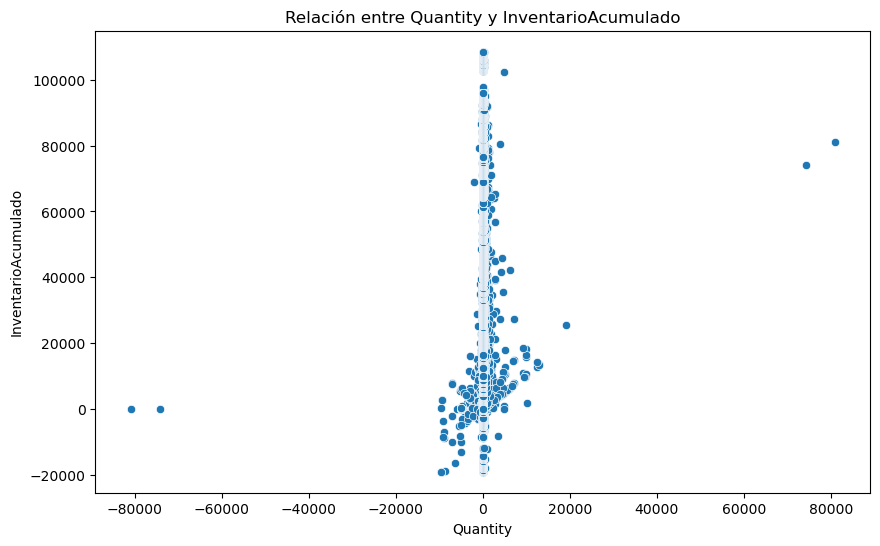

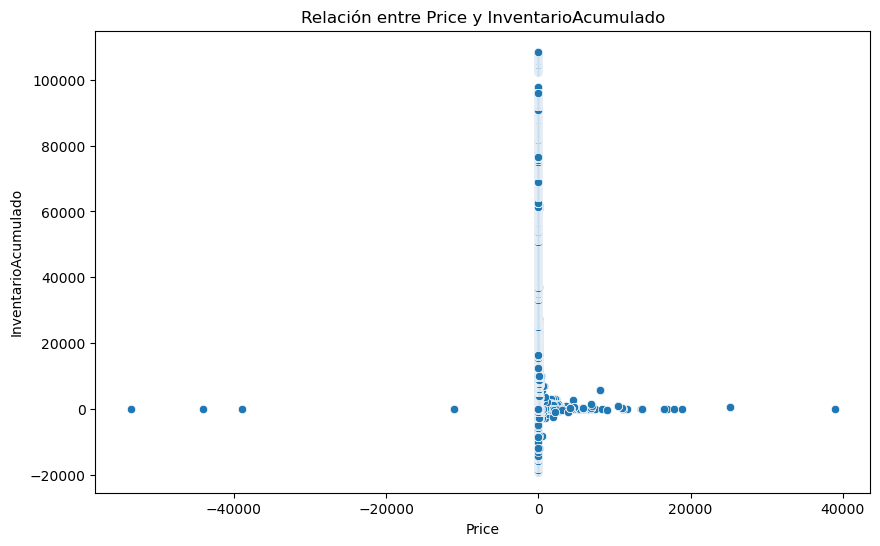

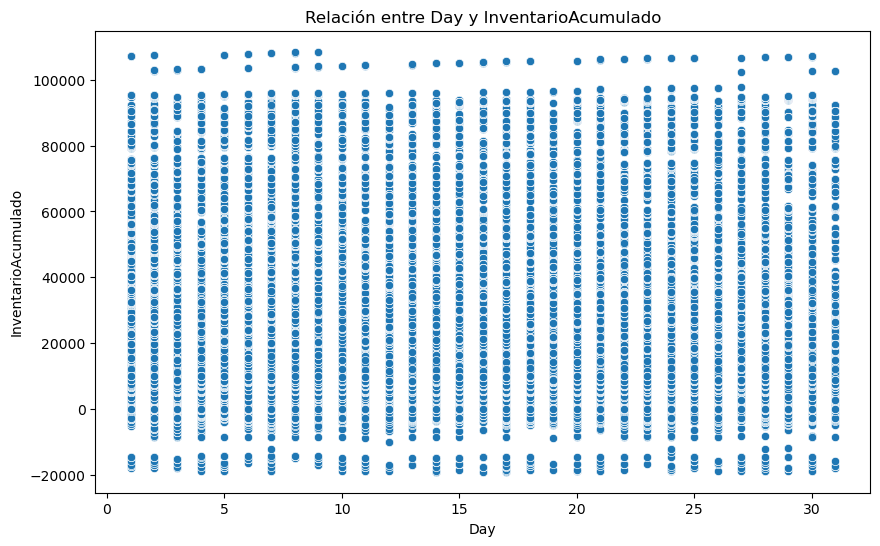

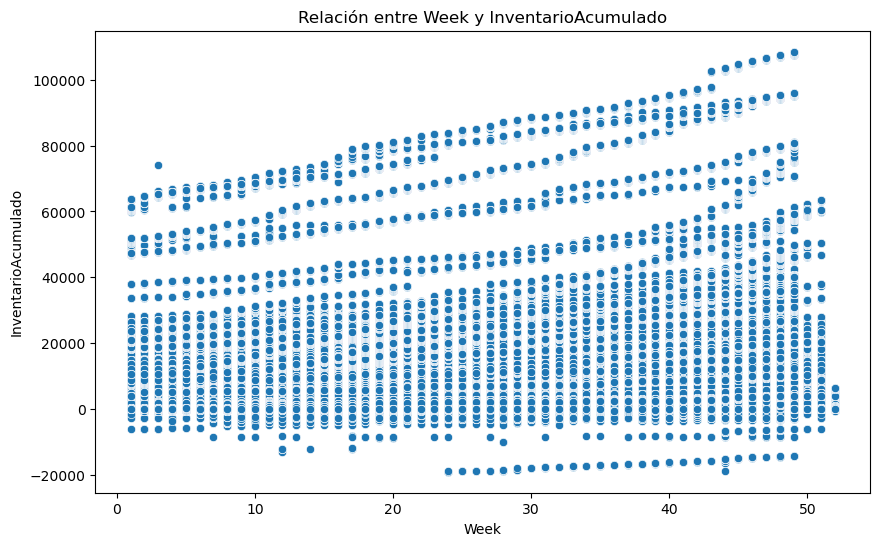

In [ ]:
%matplotlib inline
# Variables a considerar en la visualización
variables_to_plot = ['Quantity', 'Price', 'Day', 'Week', 'Month']

# Loop para crear gráficos
for variable in variables_to_plot:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_parquet_copia.toPandas(), x=variable, y='InventarioAcumulado')
    plt.title(f'Relación entre {variable} y InventarioAcumulado')
    plt.xlabel(variable)
    plt.ylabel('InventarioAcumulado')
    plt.show()


In [34]:
# Guardar el DataFrame en formato Parquet
df_parquet_copia.write.parquet("datasets/online_retail_set")

# Puedes reemplazar "/ruta/del/archivo/df_parquet_i" con la ruta deseada y el nombre de archivo.
